In [1]:
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

def ShiftAndSum(data, coordinates,):

    beamforming_phases = PhaseModel(coordinates)
    # dims = (120, n_beamform_pts,)
    phase_shift = np.exp(-1j * (beamforming_phases))

    # dims data = (120,)
    # dims phase_shift = (120, n_beamform_pts,)
    # summed dims = (n_beamform_pts,)

    summed_signal = (
        (phase_shift)[:, :,] * data[:, np.newaxis,]).sum(0)

    return summed_signal

def PhaseModel(coordinates, roll=0):

    
    ant_angles = np.arange(0, 120, 1) * 3
    r_array = 0.1
    wavelength = 3e8 / 25.86e9

    x_array = r_array * np.cos(np.radians(ant_angles))
    y_array = r_array * np.sin(np.radians(ant_angles))
    x_coord, y_coord = coordinates[:, 0], coordinates[:, 1]

    d = np.sqrt(
        (x_array[:, np.newaxis] - x_coord[np.newaxis, :]) ** 2
        + (y_array[:, np.newaxis] - y_coord[np.newaxis, :]) ** 2
        )
    arctan = np.arctan2(
        y_array[:, np.newaxis] - y_coord[np.newaxis, :],
        x_array[:, np.newaxis] - x_coord[np.newaxis, :]
        )

    spatial = 2*np.pi * d / wavelength
    phase = np.unwrap(np.roll(spatial+arctan, roll, axis=0), axis=0)
    phase -= phase[0, :][np.newaxis, :]
    
    return -phase

def Beamforming(data, x_array, y_array):
    x_grid, y_grid = np.meshgrid(x_array, y_array)
    beamforming_coordinates = np.array([x_grid.flatten(), y_grid.flatten()]).T
    
    summed_data = ShiftAndSum(data, beamforming_coordinates).reshape(x_grid.shape)
    image = abs(summed_data)**2
    max_ind = np.argmax(image)
    max_val = np.max(image)
    max_ind = np.unravel_index(max_ind, x_grid.shape)
    max_position = (x_grid[max_ind[0], max_ind[1]], y_grid[max_ind[0], max_ind[1]])
    
    
    return summed_data, image, max_position, max_val

def PerfectSum(data):
    return abs((data * np.exp(-1j * np.angle(data))).sum()) ** 2
    
    
def Loop(data):
    
    x_array = np.linspace(-0.06, 0.06, 121)
    y_array = np.linspace(-0.06, 0.06, 121)
    
    images = np.zeros((data.shape[0], data.shape[1], 121, 121))
    summed_data = np.zeros((data.shape[0], data.shape[1], 121, 121), dtype=np.complex128)
    max_position = np.zeros((data.shape[0], data.shape[1], 2,))
    
    max_val = np.zeros((data.shape[0], data.shape[1]))
    max_val_ideal_phase = np.zeros((data.shape[0], data.shape[1]))
    
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            
            summed_data[i, j, :, :], images[i, j, :, :], max_position[i, j, :], max_val[i, j] = Beamforming(data[i, j, :], x_array, y_array)
            max_val_ideal_phase[i, j] = PerfectSum(data[i, j, :])
            
            
        print(i+1,)
    return {'sum_data': summed_data, 'images': images, 'max_pos': max_position, 'max_val': max_val, 'max_val_ideal_phase': max_val_ideal_phase}
            
            
    



#file_repo = Path.home()/'iCloud'/'penn_state_synca_data'/'dig'/'synca1_5slot_scan'
#file_name = '230102_synca1_5slot_scan_fft_corrected_phases.npy'

#data = np.load(file_repo/file_name)

#print(data.shape)



In [43]:

beamforming_result = Loop(data[:,:,np.arange(0,120,1)])


1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [44]:
print(beamforming_result.keys())




dict_keys(['sum_data', 'images', 'max_pos', 'max_val', 'max_val_ideal_phase'])


In [125]:
# save the beamforming result
file_name = '230104_synca1_5slot_scan_beamforming_results.npz'
np.savez(file_repo/file_name, **beamforming_result)


In [2]:
# load the beamforming result
file_location = Path.home()/'group'/'project'/'datasets'/'data'/'230412_jugaad_analysis'
file_name = '230104_synca1_5slot_scan_beamforming_results.npz'
beamforming_result = np.load(file_location/file_name)



In [3]:
print(beamforming_result['images'].shape)

(14, 10, 121, 121)


In [4]:
sns.set_theme(context='paper', style='ticks', font_scale=1.5,)
cmap = sns.color_palette('viridis', as_cmap=True)

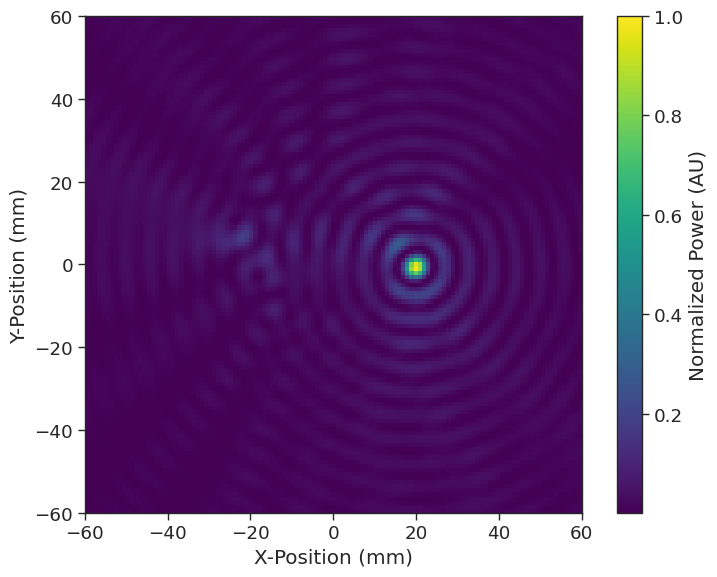

In [5]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('X-Position (mm)')
ax.set_ylabel('Y-Position (mm)')

axial_ind = 4 # 4 == zero position
radial_ind = 6 # 2 == zero position

image = beamforming_result['images'][axial_ind,radial_ind]/np.max(beamforming_result['images'][axial_ind,radial_ind])
image = np.flip(image, axis=1)

img = ax.imshow(
    image,
    cmap=cmap,
    extent = (-60, 60, -60, 60)
)
cbar = fig.colorbar(img, label='Normalized Power (AU)')
plt.tight_layout(pad=1.05)

plt.savefig(Path.home()/'group'/'project'/'plots'/'230925_z00r20_synth_bf',dpi=150)

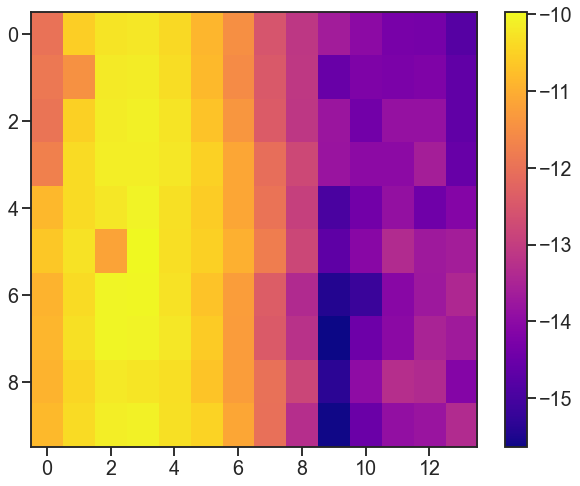

In [102]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)

axial_ind = 12
radial_ind = 

img = ax.imshow(
    np.flip(np.log(beamforming_result['max_val'].T), axis=0),
    cmap=cmap,
    aspect='auto',
    
)
cbar = fig.colorbar(img)

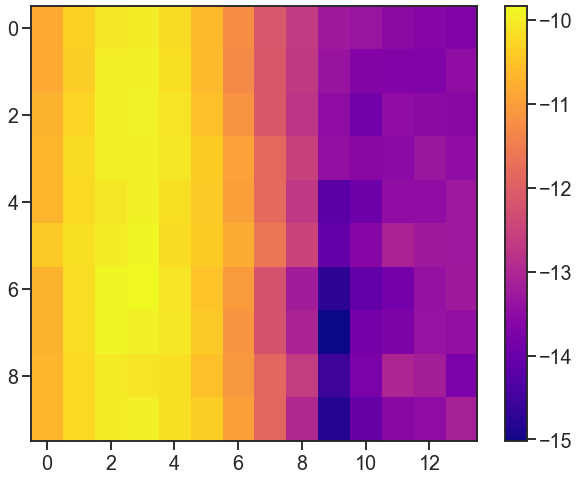

In [103]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)

axial_ind = 12
radial_ind = 0

img = ax.imshow(
    np.flip(np.log(beamforming_result['max_val_ideal_phase'].T), axis=0),
    cmap=cmap,
    aspect='auto',
    
)
cbar = fig.colorbar(img)

In [104]:
sns.set_theme(context='talk', style='whitegrid', font_scale=1.2)

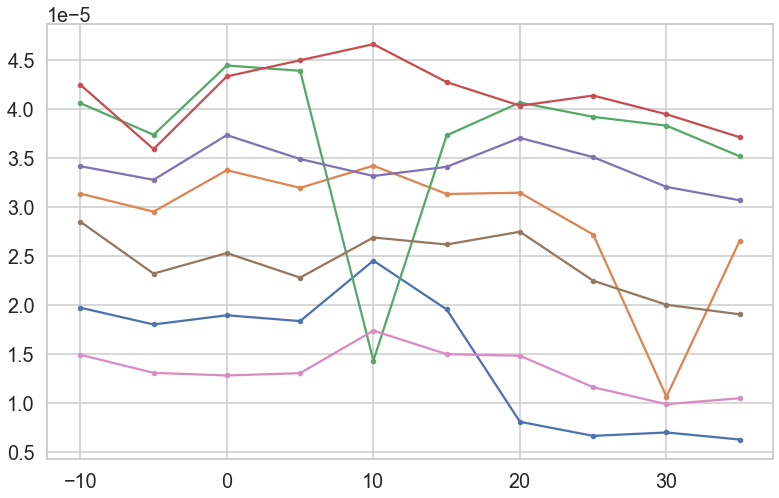

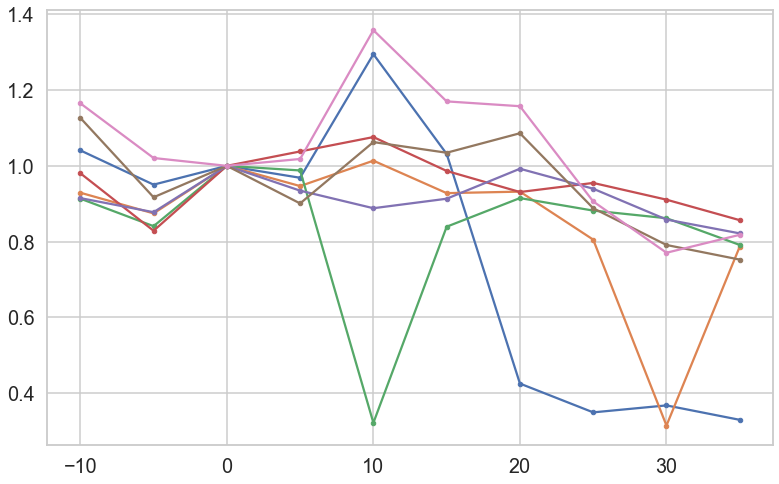

In [120]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(1,1,1)

for i in range(7):
    
    ax.plot(np.arange(-10, 40, 5), beamforming_result['max_val'][i, :], ls='-', marker='.')
    
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(1,1,1)

for i in range(7):
    
    ax.plot(np.arange(-10, 40, 5), beamforming_result['max_val'][i, :] / beamforming_result['max_val'][i, 2], ls='-', marker='.')

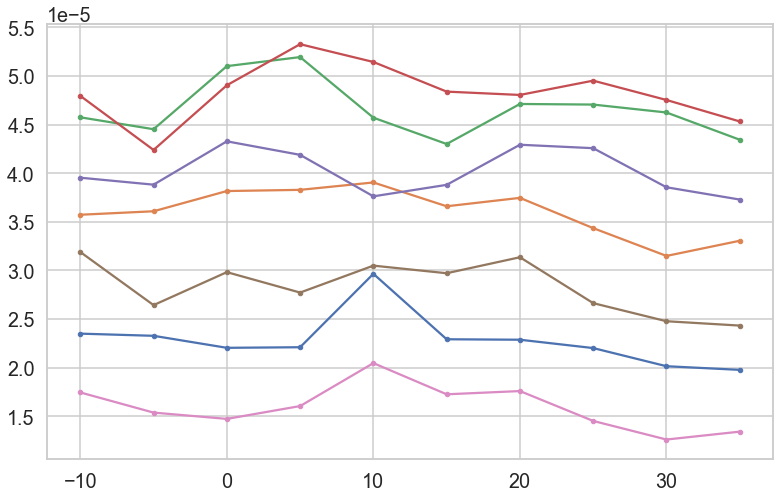

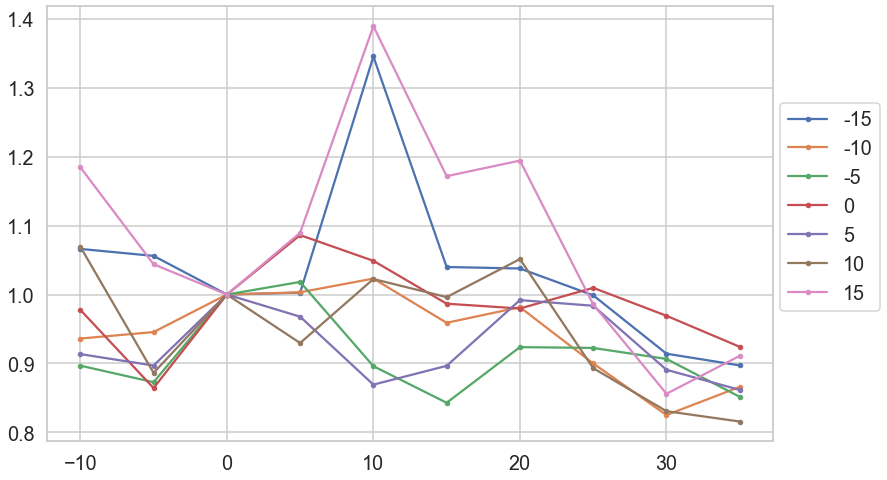

In [123]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(1,1,1)

for i in range(7):
    
    ax.plot(np.arange(-10, 40, 5), beamforming_result['max_val_ideal_phase'][i, :], ls='-', marker='.')


fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(1,1,1)

for i in range(7):
    
    ax.plot(np.arange(-10, 40, 5), beamforming_result['max_val_ideal_phase'][i, :] / beamforming_result['max_val_ideal_phase'][i, 2], ls='-', marker='.', label=f'{5*i-15}')

ax.legend(loc=(1.01, 0.3))

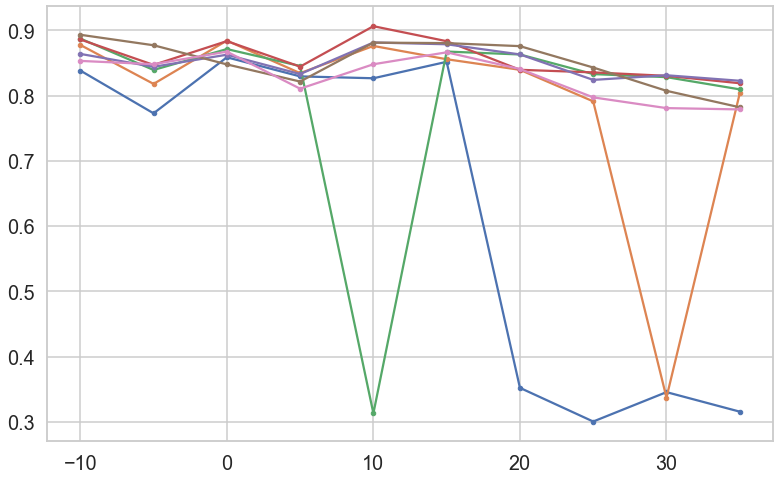

In [122]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(1,1,1)

for i in range(7):
    
    ax.plot(np.arange(-10, 40, 5), beamforming_result['max_val'][i, :] / beamforming_result['max_val_ideal_phase'][i, :], ls='-', marker='.')

